In [1]:
import pandas as pd
pd.set_option('max_colwidth', 1000)
df = pd.read_json("017_after_kaldi_anchor_separated.jsonl", lines = True)


In [2]:
df[df.kaldi_transcript == ""].shape[0] / df.shape[0]

0.12205891247807416

We have 15% of instances where Kaldi could not find transcriptions

In [3]:
c = df[df.kaldi_transcript != ""]
(c.end - c.start ).sum()/60**2


71.15963888888889

The remaining parts make up for 68 hours of data. Let us see how the transcriptions look like and if they are stable:

Let's check if any files are missing:

In [4]:
df["segment_file"] = df.apply(lambda row:
    row["file"].replace(".wav", "").replace("audio", "seg_audio") + f'__{row["start"]:.1f}__{row["end"]:.1f}__.wav',
    axis=1
)

for file in df.segment_file:
    from pathlib import Path
    p = Path(file)
    if not p.exists():
        print("Segment", p, "does not exist!")



Optional step:

delete rows where we have empty kaldi outputs and delete corresponding audio files:

In [5]:
filtered_df = df[df.kaldi_transcript != ""]

loc = Path("seg_audio")
for segmentfile in loc.glob("*.wav"):
    if str(segmentfile) not in filtered_df["segment_file"]:
        # segmentfile.unlink()
        continue

Let's transform the string representations into proper pythonic lists:

In [6]:
from ast import literal_eval

filtered_df.loc[:, "kaldi_transcript"] = filtered_df.kaldi_transcript.str.replace("πππ", r"<anchor_end>").str.replace("ππ", r"<anchor_start>").str.replace("<unk>", "<anchor_start>")
filtered_df.loc[:, "kaldi_words"] = filtered_df.kaldi_words.str.replace("πππ", r"<anchor_end>").str.replace("ππ", r"<anchor_start>").str.replace("<unk>", "<anchor_start>")

filtered_df.loc[:, "kaldi_words"] = filtered_df.kaldi_words.apply(literal_eval)
filtered_df.loc[:, "kaldi_word_ends"] = filtered_df.kaldi_word_ends.apply(literal_eval)
filtered_df.loc[:, "kaldi_word_starts"] = filtered_df.kaldi_word_starts.apply(literal_eval)



/home/rupnik/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
filtered_df.to_json("018_juzne_vesti_anchor_separated.jsonl", lines=True, orient="records")

In [8]:
filtered_df.columns

Index(['file', 'start', 'end', 'asr_transcription', 'webpage_transcript',
       'ratio', 'text', 'kaldi_transcript', 'kaldi_words', 'kaldi_word_starts',
       'kaldi_word_ends', 'segment_file'],
      dtype='object')

In [9]:
#filtered_df[['file', 'asr_transcription', "webpage_transcript",'kaldi_transcript']].head(50)

In [10]:
corpus = pd.read_json("020_JV_with_metadata.jsonl", orient="records", lines=True)
corpus = corpus["path guest_name guest_description host".split()]
corpus.columns, filtered_df.columns

(Index(['path', 'guest_name', 'guest_description', 'host'], dtype='object'),
 Index(['file', 'start', 'end', 'asr_transcription', 'webpage_transcript',
        'ratio', 'text', 'kaldi_transcript', 'kaldi_words', 'kaldi_word_starts',
        'kaldi_word_ends', 'segment_file'],
       dtype='object'))

In [11]:
merged_df = pd.merge(
    left=filtered_df,
    right = corpus,
    how = "left",
    left_on="file",
    right_on="path"
)

merged_df = merged_df["file start end asr_transcription kaldi_transcript guest_name guest_description host kaldi_words kaldi_word_starts kaldi_word_ends segment_file".split()]

In [12]:
from Levenshtein import distance as lev

def calculate_average_distance(s1, s2):
    s1 = s1.replace("<anchor_start>", "").replace("<anchor_end>", "")
    s2 = s2.replace("<anchor_start>", "").replace("<anchor_end>", "")
    distances = [lev(w1, w2) for w1, w2 in  zip(s1.split(), s2.split())]
    from numpy import mean
    return mean(distances)


def calculate_similarity_ratio(s1, s2):
    s1 = s1.replace("<anchor_start>", "").replace("<anchor_end>", "")
    s2 = s2.replace("<anchor_start>", "").replace("<anchor_end>", "")
    from fuzzywuzzy import fuzz
    ratio = fuzz.ratio(s1, s2)
    return ratio

merged_df["average_distance"] = merged_df.apply(
    lambda row: calculate_average_distance(row["asr_transcription"], row["kaldi_transcript"]),
    axis=1
    )
merged_df["similarity_ratio"] = merged_df.apply(
    lambda row: calculate_similarity_ratio(row["asr_transcription"], row["kaldi_transcript"]),
    axis=1
    )

In [13]:
merged_df.to_json("021_JV_segments_with_metadata.jsonl", orient="records", lines=True)

In [14]:
merged_df["asr_len"] = merged_df.asr_transcription.str.len()

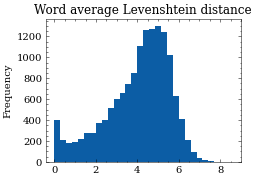

In [15]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])


merged_df.average_distance.plot.hist(bins=30)
plt.title("Word average Levenshtein distance")
plt.show()


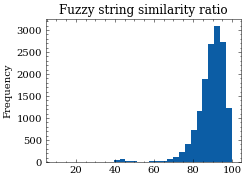

In [16]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex'])

merged_df.similarity_ratio.plot.hist(bins=30)
plt.title("Fuzzy string similarity ratio")

plt.show()

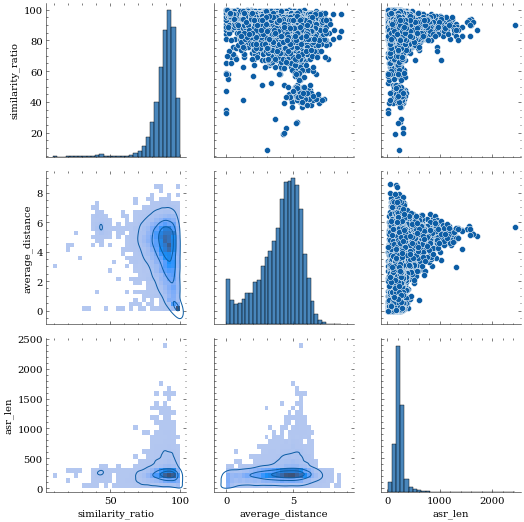

In [17]:
import seaborn as sns

# b = sns.pairplot(data=merged_df, vars=["similarity_ratio", "average_distance"], kind="scatter", diag_kind="kde")
# b.map_lower(sns.histplot, bins=30)



g = sns.PairGrid(data=merged_df, vars=["similarity_ratio", "average_distance", "asr_len"],
diag_sharey=False, 
# hue="asr_len",
# corner=True
)
g.map_lower(sns.histplot, bins=30)
g.map_diag(sns.histplot, bins=30)
g.map_lower(sns.kdeplot, levels=4)
g.map_upper(sns.scatterplot)

# plt.savefig("images/018_pairplot.png", dpi=100, transparent=False, facecolor="white")
plt.show()


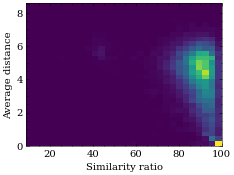

In [18]:
plt.hist2d(merged_df.similarity_ratio, merged_df.average_distance, bins=30)
plt.xlabel("Similarity ratio")
plt.ylabel("Average distance")
plt.show()

In [19]:
merged_df["asr_transcription kaldi_transcript average_distance similarity_ratio".split()].sort_values(by="similarity_ratio").iloc[250:256, :]

,asr_transcription,kaldi_transcript,average_distance,similarity_ratio
10401,e sad pitali su me više puta ovako da li poli da li ne boli da li bori ali ne fizički duše na bolji,pitali su me više puta da li boli to što sam izgubio obe ruke primaut da li ne boli boli alii ne fizički to je duševna bol,3.875000,69
13399,jedini mediji koji onako ličina ali kažemo opoziciji i to je onjedinik vreme i tu je okrilik je ajdu kažemo a ni i to je početak i kraj toga nemate dakle ali vi nemate mogućnost doselite to jer jednostavno vlasnicima,jedini medij koji liči na opozicioni to je nedeljnik vreme i nin to je početak i kraj toga vi nemate mogućnost jer vlasnicima,4.695652,69
1840,drugo vjmoram reći da tu je veliku ulogu odigala i zasićenost zemlje odnosno tla vodom koja je zastitila tlo tokom prethodnik kiše u aprilu tako da je praktično,moram reći da u tome veliku ulogu odigrala zasićenost zemlje vodom koja je zasitila tlo tokom prethodnih padavina u aprilu tako da je područje reagovalo mnogo brže na pojavu tolikoh padavina u smislu poplava <anchor_start>da li je,5.535714,69
13377,ta misija ima jeli nema dovoljan rejting m isplaćuje se isplaćuje se i da vam to bude razlog za takvo nešto uređeno je su više trapovu i to što je uređeno n na taj način to vam stvara neki utisak gdje tu nešto nije čisto nisu čisto posla jednostavno,ta emisija ima ili nema dovoljan rejting ne isplaćuj se ili se isplaćuje i da vam to bude razlog za tako nešto urađeno je suviše trapavo i to što je,2.266667,69
13836,s obzirom da evo kao što i vaša funkcija kaže koordinator i da sam ja morato vas pitam šta j jer sam ja često ogrešio k sam pitao čak neke funkcionira srpske napredne stranke pa upotrebim izraz povjerenika oni ma ispravljaju ne nije nego je koordinator ako građani ne znaju,obzirom da kao i što vaša funkcija kaže koordinator i da ja moram da vas pitam šta je jer sam i ja često grešio pa upotrebim izraz poverenik a oni me isprave ako građani neznaju ko vodi najveću i najutcajniju stranku u nišu kako da znaju,4.978261,69
8055,problem je i porodice problem je i vaspitnih ustanova iz svega ostalog znači naravno policija kao policija ne možda bude na svakom koraku gradu bi da kažem štitila taj poredak i ne možemo mi sada da imamo,prblem je i porodice problem je i vaspitnih istanova i svega ostalog policija ne može da bude na svakom koraku u gradu da bi štitila taj poredak i ne možemo da grad koji ima tristonula stanovnika da ima tristonula policajaca ali činjenica je to da gledajući pokazatelje koje imamo,3.378378,69
